In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import figformat as ff
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import shape
A4 = ff.get_A4size()
FSIZE = A4['FSIZE']

In [29]:
def file_reader(path):
    df_table = pd.read_table(path,header=None)
    data = pd.DataFrame()
#     data['x'] = df_table[0] # longitude
    x_mod = np.zeros(len(df_table[0].values))
    for i,x in enumerate(df_table[0].values):
        if x > 0:
            x_mod[i] = x
        if x < 0:
            x_mod[i] = 360 + x
    data['x'] = x_mod[np.where(np.isnan(df_table[2].values)==False)]
    data['y'] = df_table[1].values[np.where(np.isnan(df_table[2].values)==False)] # latitude
    data['z'] = df_table[2].values[np.where(np.isnan(df_table[2].values)==False)] # elevation
    return data

def elevation_percentileRange_from_path_list(path_list,minp=5,maxp=95):
    minE = []
    maxE = []
    for path in path_list:
        data = file_reader(path)
        minE.append(np.percentile(data['z'],minp))
        maxE.append(np.percentile(data['z'],maxp))
    return (np.min(minE),np.max(maxE))

def channel_interpolator(data,sigma=1,kind='cubic'):
    Z = data.pivot_table(index='x', columns='y', values='z').T.values # Elevation
    X_unique = np.sort(data.x.unique()) # X_axis 
    Y_unique = np.sort(data.y.unique()) # Y_axis
    X, Y = np.meshgrid(X_unique, Y_unique) # grid
    grad = np.gradient(gaussian_filter(Z,sigma=sigma)) # grid of local slope(Sx,Sy)
    mag = np.sqrt(grad[0]**2 + grad[1]**2) # local slope grid (Sxy)
    
    # fe = interpolate.RegularGridInterpolator( (X_unique, Y_unique), gaussian_filter(Z,sigma=sigma),bounds_error=False, fill_value=None, method='cubic') # Interepolated elevation
    # fm = interpolate.RegularGridInterpolator( (X_unique, Y_unique), mag, bounds_error=False, fill_value=None, method='cubic') # Interpolated slope
    
    fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
    fm = interpolate.interp2d(X_unique, Y_unique, mag, kind='cubic') # Interpolated slope
    return (X,Y,Z,mag), (fe, fm)

def cumulative_distance(CX,CY,CZ):
    distance_array = np.zeros(len(CX))
    for i in range(len(CX)):
        if i == 0:
            distance_array[0] = 0
        else:
            distance_array[i] = np.sqrt((CX[i]-CX[i-1])**2 + (CY[i]-CY[i-1])**2 + (CZ[i]-CZ[i-1])**2)
    CD = np.cumsum(distance_array)
    return CD

def read_centreline_fromXYZ(path,grids,fields,cut=True):
    X, Y, Z, mag = grids # Grid data
    fe, fm = fields # interpolated grid of elevation and slope
    df = pd.read_table(path)
    CX = np.array(df['Longitude'].values)
    x_mod = np.zeros(len(CX))
    for i,x in enumerate(CX):
        if x > 0:
            x_mod[i] = x
        if x < 0:
            x_mod[i] = 360 + x
    CX = x_mod
    CY = np.array(df['Latitude'].values)
    if cut:
        CX = CX[np.where(CX <= np.max(X))]; CY = CY[np.where(CX <= np.max(X))]
        CX = CX[np.where(CX >= np.min(X))]; CY = CY[np.where(CX >= np.min(X))]
        CX = CX[np.where(CY <= np.max(Y))]; CY = CY[np.where(CY <= np.max(Y))]
        CX = CX[np.where(CY >= np.min(Y))]; CY = CY[np.where(CY >= np.min(Y))]
    CX = list(CX); CY = list(CY)
    CZ = []
    for i in range(len(CX)):
        CZ.append(fe(CX[i],CY[i]))
    CD = cumulative_distance(CX,CY,CZ)
    DEV = np.nan
    return (CX,CY,CZ,CD,DEV)

def detect_centreline(data, fields, radius, step, debug_params = (2,1500,5,95,0), hM_std = 2.5, sight_angle = np.pi/4, resolution = 12, moment_num = 3, start_position = 'None', start_loc = [np.nan,np.nan],max_iteration = 1000):   
    X, Y, Z, mag = data # Grid data
    fe, fm = fields # interpolated grid of elevation and slope
#     print('CHECK:',np.any(np.isnan(start_loc)))
#     print('CHECK:',start_loc)
    rad_array = np.linspace(-sight_angle,sight_angle,resolution) # radian 
    debug_radius_ratio, debug_std, hpl, hph, sigma = debug_params # expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
    Z = gaussian_filter(Z,sigma=sigma)
    # Define start point
    if start_position == 'None':
        minz_array = np.ones(5)
        start_array = np.ones(5)
        pos_array = ['left','right','top','bottom','topright']
    #     pos_array = ['right','left','bottom','top']
        #left
        X_array = X[:,0]; Y_array = Y[:,0]; Z_array = Z[:,0]; S_array = mag[:,0]
        minz_array[0] = np.min(Z_array)
        start_array[0] = np.argmin(Z_array)
        #right
        X_array = X[:,-1]; Y_array = Y[:,-1]; Z_array = Z[:,-1]; S_array = mag[:,-1]
        minz_array[1] = np.min(Z_array)
        start_array[1] = np.argmin(Z_array)
        #top
        X_array = X[-1,:]; Y_array = Y[-1,:]; Z_array = Z[-1,:]; S_array = mag[-1,:]
        minz_array[2] = np.min(Z_array)
        start_array[2] = np.argmin(Z_array)
        #bottom
        X_array = X[0,:]; Y_array = Y[0,:]; Z_array = Z[0,:]; S_array = mag[0,:]
        minz_array[3] = np.min(Z_array)
        start_array[3] = np.argmin(Z_array)
        
        # estimate position    
        position = pos_array[np.argsort(minz_array)[1]]
        start = start_array[np.argsort(minz_array)[1]].astype(int)
    
    position = start_position
    if position == 'left':
        Z_array = Z[:,0];
        start = np.argmin(Z_array)
        clp_ind = [start,0] # define current location index
    elif position == 'right':
        Z_array = Z[:,-1];
        start = np.argmin(Z_array)
        clp_ind = [start,-1] # define current location index
        rad_array += np.pi
    elif position == 'righttop':
        Z_array = Z[int(len(Z[:,-1])/2):,-1];
        start = np.argmin(Z_array) + int(len(Z[:,-1])/2)
        clp_ind = [start,-1] # define current location index
        rad_array += np.pi
    elif position == 'bottom':
        Z_array = Z[0,:];
        start = np.argmin(Z_array)
        clp_ind = [0,start] # define current location index
        rad_array += np.pi/2
    elif position == 'bottomleft':
        Z_array = Z[0,:int(len(Z[0,:])/2)];
        start = np.argmin(Z_array) 
        clp_ind = [0,start] # define current location index
        rad_array += np.pi/2
    elif position == 'top':
        Z_array = Z[-1,:];
        start = np.argmin(Z_array)
        clp_ind = [-1,start] # define current location index
        rad_array += -np.pi/2
    elif position == 'topright':
        Z_array = Z[-1,int(len(Z[-1,:])/2):];
        start = np.argmin(Z_array) + int(len(Z[-1,:])/2)
        clp_ind = [-1,start] # define current location index
        rad_array += -np.pi/2
    elif position == 'toprightright':
        Z_array = Z[-1,int(3*len(Z[-1,:])/4):];
        start = np.argmin(Z_array) + int(3*len(Z[-1,:])/4)
        clp_ind = [-1,start] # define current location index
        rad_array += -np.pi/2
    
    if np.any(np.isnan(start_loc)):
        clp_x = X[clp_ind[0],clp_ind[1]];    clp_y = Y[clp_ind[0],clp_ind[1]];    clp_z = Z[clp_ind[0],clp_ind[1]]
    else:
        clp_x = start_loc[0]; clp_y = start_loc[1]; clp_z = fe(clp_x,clp_y)

    clp = [clp_x,clp_y]
    CX = [clp_x];    CY = [clp_y];    CZ = [clp_z];   CD = [0];
    DEV = [0]
    
    def pointChecker(clp,count,max_iteration):
        if clp[0] < np.min(X[0,:]) or clp[0] > np.max(X[0,:]) or clp[1] < np.min(Y[:,0]) or clp[1] > np.max(Y[:,0]) or count > max_iteration:
            return False
        else:
            count += 1
            return True
    count = 0
    direc_array = rad_array
    dev_array = np.zeros(len(rad_array)) # deviation of slope
    hM_array = np.zeros(len(rad_array)) # maximum elevation 
#     distance_array = [0]
    direc_temp = np.ones(moment_num)*np.mean(rad_array)
    direc = np.mean(direc_array)
    while(pointChecker(clp,count,max_iteration)):
        count += 1
        ind_array = np.arange(len(direc_array))
        for i,rad in enumerate(direc_array): 
#             # short range
            lx = np.cos(rad) * radius + clp_x; ly = np.sin(rad) * radius + clp_y
            lx = np.linspace(clp_x,lx,20); ly = np.linspace(clp_y,ly,20)
            if lx[-1] > np.max(X) or lx[-1] < np.min(X) or ly[-1] > np.max(Y) or ly[-1] < np.min(Y):
                lx = np.linspace(clp_x,lx[-1],20); ly = np.linspace(clp_y,ly[-1],20)
                lx = lx[np.where(lx <= np.max(X))]; ly = ly[np.where(lx <= np.max(X))]
                lx = lx[np.where(lx >= np.min(X))]; ly = ly[np.where(lx >= np.min(X))]
                lx = lx[np.where(ly <= np.max(Y))]; ly = ly[np.where(ly <= np.max(Y))]
                lx = lx[np.where(ly >= np.min(Y))]; ly = ly[np.where(ly >= np.min(Y))]
                lx = np.linspace(clp_x,lx[-1],20); ly = np.linspace(clp_y,ly[-1],20)
            lz = fe(lx,ly); lm = fm(lx,ly)
#             lz = np.array([fe(lx[k],ly[k]) for k in range(len(lx))]); lm = np.array([fm(lx[k],ly[k]) for k in range(len(lx))])
            H_eval = np.percentile(lz,hph)/np.percentile(lz,hpl)
            m_eval = np.sum(lm[np.where(lz >= clp_z)]*H_eval)
            m_dev = np.std(lm[np.where(lz >= clp_z)])
            hM_array[i] = np.max(lz) - clp_z
            dev_array[i] = m_eval
#             dev_array[i] = m_eval * (1 + m_dev)
        if np.std(dev_array) < debug_std:
            for i,rad in enumerate(direc_array): # -pi/2 < rad < pi/2
                lx = np.cos(rad) * radius*debug_radius_ratio + clp_x 
                ly = np.sin(rad) * radius*debug_radius_ratio + clp_y
                lx = np.linspace(clp_x,lx,10); ly = np.linspace(clp_y,ly,10)
                if lx[-1] > np.max(X) or lx[-1] < np.min(X) or ly[-1] > np.max(Y) or ly[-1] < np.min(Y):
                    lx = np.linspace(clp_x,lx[-1],20); ly = np.linspace(clp_y,ly[-1],20)
                    lx = lx[np.where(lx <= np.max(X))]; ly = ly[np.where(lx <= np.max(X))]
                    lx = lx[np.where(lx >= np.min(X))]; ly = ly[np.where(lx >= np.min(X))]
                    lx = lx[np.where(ly <= np.max(Y))]; ly = ly[np.where(ly <= np.max(Y))]
                    lx = lx[np.where(ly >= np.min(Y))]; ly = ly[np.where(ly >= np.min(Y))]
                    lx = np.linspace(clp_x,lx[-1],20); ly = np.linspace(clp_y,ly[-1],20)
                lz = np.array([fe(lx[k],ly[k]) for k in range(len(lx))]);
                lm = np.array([fm(lx[k],ly[k]) for k in range(len(lx))])
                H_eval = np.percentile(lz,hph)/np.percentile(lz,hpl)
                m_eval = np.sum(lm[np.where(lz >= clp_z)]*H_eval)
                m_dev = np.std(lm[np.where(lz >= clp_z)])
                hM_array[i] = np.max(lz) - clp_z
                dev_array[i] = m_eval        
        DEV.append( np.std(hM_array) )
        if np.std(hM_array) < hM_std:
            direc = direc_array[np.argmin(dev_array)]
            direc_temp[count%moment_num] = direc
        else:
            direc = direc_array[np.argmin(hM_array)]
            direc_temp[count%moment_num] = direc

        rad_array = np.linspace(-sight_angle,sight_angle,resolution) # radian 
        direc_array = rad_array + np.mean(direc_temp)
        lx = np.cos(direc) * radius + clp_x
        ly = np.sin(direc) * radius + clp_y
        lx = np.linspace(clp_x,lx,100)
        ly = np.linspace(clp_y,ly,100)
        dx = np.cos(direc) * step
        dy = np.sin(direc) * step
        dz = clp_z - fe(clp_x+dx,clp_y+dy)
        # assign
        clp_x += np.cos(direc) * step
        clp_y += np.sin(direc) * step
        clp_z = fe(clp_x,clp_y)
        CX.append(float(clp_x))
        CY.append(float(clp_y))
        CZ.append(float(clp_z))
        clp = [clp_x,clp_y]
    CD = cumulative_distance(CX,CY,CZ)
    return (CX,CY,CZ,CD,DEV)


In [31]:
Congo_meander = pd.DataFrame()
Congo_X = []
Congo_Y = []
Congo_Z = []
Congo_D = []

FILE_PATH_LIST = ['Raw/XYZ/Congo/Congo_03_WR.xyz',
                  'Raw/XYZ/Congo/Congo_04_WR.xyz',
                  'Raw/XYZ/Congo/Congo_05_WR.xyz',
                  'Raw/XYZ/Congo/Congo_06_WR.xyz',
                  'Raw/XYZ/Congo/Congo_07_WR.xyz',
                  'Raw/XYZ/Congo/Congo_08_WR.xyz'
                 ]
# (debug_radius_ratio, debug_
debug_param = [(1,0,5,95,0), # 03
              (1,0,5,95,0),  # 04
              (1,0,5,95,0), #05
              (1,0,5,95,0), #06
#               (2,1500,5,95,2), #05
#               (2,1500,5,95,0), #06
              (1,0,5,95,0), #07
              (1,0,5,95,0), #08
             ]
start_pos = [
    'right', #03
    'right', #04
    'right', #05
    'right', #06
    'right', #07
    'right' #08
]
moment_num = [
    1, # 03
    1, # 04
    1, # 05
    1, # 06
    1, # 07
    1 # 08
]
file_name = [
    'Congo_03.pdf',
    'Congo_04.pdf',
    'Congo_05.pdf',
    'Congo_06.pdf',
    'Congo_07.pdf',
    'Congo_08.pdf',
]
success_centreline = [
    True, 
    True,
    True,
    True,
    True,
    True
]
start_position = []
radius = 0.002
step = 0.0005
count = 0
clp_x=0
clp_y=0
clp_d=0
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []

# centre line detection
for i,path in enumerate(FILE_PATH_LIST):
    # file path
    print(path)
    
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    
    # get centrelines and exception handling
    if count == 0 : 
        centre_line = detect_centreline(grids,fields,radius,step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
    elif success_centreline[i] == False:
        centre_line = detect_centreline(grids,fields,radius,step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
    elif success_centreline[i] == True:
        centre_line = detect_centreline(grids,fields,radius,step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    if success_centreline[i]:
        clp_x = CX[-1]
        clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    # print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    
    for j,val in enumerate(CZ):
        if type(val) in (list,np.ndarray):
            CZ[j] = val[0]
    bx.plot(CD_c ,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1

# Save the end point
CLP8 = (clp_x,clp_y)

# plot summary
fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo03to08.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo03to08.csv')

Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all
cumD = np.max(Congo_D)

Raw/XYZ/Congo/Congo_03_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

551
Raw/XYZ/Congo/Congo_04_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

441
Raw/XYZ/Congo/Congo_05_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

585
Raw/XYZ/Congo/Congo_06_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

651
Raw/XYZ/Congo/Congo_07_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

690
Raw/XYZ/Congo/Congo_08_WR.xyz


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

570


/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fe = interpolate.interp2d(X_unique, Y_unique, gaussian_filter(Z,sigma=sigma), kind='cubic') # Interepolated elevation
/var/folders/qs/s0s216ks5v5_wrlm1hg43s4h0000gn/T/ipykernel_79216/1489213741.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivar

In [4]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_09_WR.xyz',
    'Raw/XYZ/Congo/Congo_10_WR.xyz',
    'Raw/XYZ/Congo/Congo_11_WR.xyz',
                 ]
centreline_path = [
    '',
    '',
    'Raw/XYZ/Congo/Congo_11_WR_centre.xyz'
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #09
    (1,0,5,95,0), #10
    (1,0,5,95,1), #11
]

file_name = [
    'Congo_09.pdf',
    'Congo_10.pdf',
    'Congo_11.pdf',
]
sight_angles = [
    np.pi/4, #09
    np.pi/4, #10
    np.pi/4, #11
]
start_pos = [
    'bottom', # 09
    'right', # 10
    'right', # 11
]
radius = [
    0.002,
    0.002,
    0.004
]
step = [
    0.0005,
    0.0005,
    0.0005
]

success_centreline = [
    True, 
    True,
    False,
]
start_position = []
clp_x,clp_y = CLP8
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []


count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step[i],debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step[i],debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step[i],debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields)
#     centre_line = detect_centreline(grids,fields,radius[i],step[i],debug_param[i],start_position=start_pos[i], sight_angle=sight_angles[i],max_iteration=1000)
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    if success_centreline[i]:
        clp_x = CX[-1]
        clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
CLP11 = (clp_x,clp_y)


# plot summary
fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo09to11.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo09to11.csv')


Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all
# cumD = Congo_D)
# for dis in CD_c_all:
#     Congo_D += [dis+cumD]


Raw/XYZ/Congo/Congo_09_WR.xyz
612
[  0  50 100 150 200 250 300 350 400 450 500 550 600]
Raw/XYZ/Congo/Congo_10_WR.xyz
671
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650]
Raw/XYZ/Congo/Congo_11_WR.xyz
311
[  0  50 100 150 200 250 300]


In [5]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_12_WR.xyz',
    'Raw/XYZ/Congo/Congo_13_WR.xyz',
    'Raw/XYZ/Congo/Congo_14_WR.xyz',
                 ]
centreline_path = [
    'Raw/XYZ/Congo/Congo_12_WR_centre.xyz',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #12
    (1,0,5,95,0), #13
    (1,0,5,95,0), #14
]

file_name = [
    'Congo_12.pdf',
    'Congo_13.pdf',
    'Congo_14.pdf',
]
sight_angles = [
    np.pi/4, #12
    np.pi/3, #13
    np.pi/4, #14
]
start_pos = [
    'top', # 12
    # 'right', # 13
    'top', # 13 (test)
    'right', # 14
]
radius = [
    0.002,
    0.002,
    0.002
]
success_centreline = [
    False, 
    True,
    True,
]
cuts = [
    False,
    True,
    True
]
clp_x,clp_y = CLP11
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []

step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        data_temp = file_reader(FILE_PATH_LIST[i+1]) # read next one
        grids_temp, fields_temp = channel_interpolator(data_temp,sigma=0) # load next fields
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i]) # load manually picked centreline
        
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    if success_centreline[i] == False:
        fe_temp,fm_temp = fields_temp
        for j, (x,y) in enumerate(zip(CX,CY)):
            if x < np.min(X) or y < np.min(Y):
                CZ[j] = fe_temp(x,y)
    
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1

CLP14 = (clp_x,clp_y)

# plot summary
fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=0.1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo12to14.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo12to14.csv')

Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_12_WR.xyz
255
[  0  50 100 150 200 250]
Raw/XYZ/Congo/Congo_13_WR.xyz
179
[  0  50 100 150]
Raw/XYZ/Congo/Congo_14_WR.xyz
931
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900]


In [6]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_15_WR.xyz',
    'Raw/XYZ/Congo/Congo_16_WR.xyz',
    'Raw/XYZ/Congo/Congo_17_WR.xyz',
    'Raw/XYZ/Congo/Congo_18_WR.xyz'
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,1), #15
    (1,0,5,95,1), #16
    (1,0,5,95,1), #17
    (1,0,5,95,1) #18
]

file_name = [
    'Congo_15.pdf',
    'Congo_16.pdf',
    'Congo_17.pdf',
    'Congo_18.pdf'
]
sight_angles = [
    np.pi/4, #15
    np.pi/4, #16
    np.pi/4, #17
    np.pi/4, #18
]
start_pos = [
    'right', # 15
    'right', # 16
    'right', # 17
    'right', # 18
]
radius = [
    0.003,
    0.003,
    0.003,
    0.003
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]

clp_x,clp_y = CLP14
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []
step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
CLP18 = (clp_x,clp_y)


# plot summary
fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo15to18.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo15to18.csv')

Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_15_WR.xyz
501
[  0  50 100 150 200 250 300 350 400 450]
Raw/XYZ/Congo/Congo_16_WR.xyz
734
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700]
Raw/XYZ/Congo/Congo_17_WR.xyz
755
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
Raw/XYZ/Congo/Congo_18_WR.xyz
685
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650]


In [7]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_19_WR.xyz',
    'Raw/XYZ/Congo/Congo_20_WR.xyz',
    'Raw/XYZ/Congo/Congo_21_WR.xyz',
    'Raw/XYZ/Congo/Congo_22_WR.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #19
    (1,0,5,95,0), #20
    (1,0,5,95,0), #21
    (1,0,5,95,1) #22
]

file_name = [
    'Congo_19.pdf',
    'Congo_20.pdf',
    'Congo_21.pdf',
    'Congo_22.pdf'
]
sight_angles = [
    np.pi/4, #19
    np.pi/4, #20
    np.pi/4, #21
    np.pi/4 #21
]

start_pos = [
    'right', # 19
    'right', # 20
    'right', # 21
    'bottom', # 22
]
radius = [
    0.002,
    0.002,
    0.002,
    0.002
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP18
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []

step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
CLP22 = (clp_x,clp_y)

fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo19to22.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo19to22.csv')


Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_19_WR.xyz
577
[  0  50 100 150 200 250 300 350 400 450 500 550]
Raw/XYZ/Congo/Congo_20_WR.xyz
584
[  0  50 100 150 200 250 300 350 400 450 500 550]
Raw/XYZ/Congo/Congo_21_WR.xyz
359
[  0  50 100 150 200 250 300 350]
Raw/XYZ/Congo/Congo_22_WR.xyz
549
[  0  50 100 150 200 250 300 350 400 450 500]


In [8]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_23_WR.xyz',
    'Raw/XYZ/Congo/Congo_24_WR.xyz',
    'Raw/XYZ/Congo/Congo_25_WR.xyz',
    'Raw/XYZ/Congo/Congo_26_WR.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #23
    (1,0,5,95,0), #24
    (1,0,5,95,0), #25
    (1,0,5,95,0) #36
]

file_name = [
    'Congo_23.pdf',
    'Congo_24.pdf',
    'Congo_25.pdf',
    'Congo_26.pdf'
]
sight_angles = [
    np.pi/4, #23
    np.pi/4, #24
    np.pi/4, #25
    np.pi/4 #36
]

start_pos = [
    'right', # 23
    'right', # 24
    'topright', # 25
    'right', # 26
]
radius = [
    0.002,
    0.002,
    0.002,
    0.002
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP22
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []
step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
CLP26 = (clp_x,clp_y)

fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo23to26.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo23to26.csv')

Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_23_WR.xyz
639
[  0  50 100 150 200 250 300 350 400 450 500 550 600]
Raw/XYZ/Congo/Congo_24_WR.xyz
528
[  0  50 100 150 200 250 300 350 400 450 500]
Raw/XYZ/Congo/Congo_25_WR.xyz
781
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
Raw/XYZ/Congo/Congo_26_WR.xyz
504
[  0  50 100 150 200 250 300 350 400 450 500]


In [9]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_27_WR.xyz',
    'Raw/XYZ/Congo/Congo_28_WR.xyz',
    'Raw/XYZ/Congo/Congo_29_WR.xyz',
    'Raw/XYZ/Congo/Congo_30_WR.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #27
    (1,0,5,95,0), #28
    (1,0,5,95,0), #29
    (1,0,5,95,0) #30
]

file_name = [
    'Congo_27.pdf',
    'Congo_28.pdf',
    'Congo_29.pdf',
    'Congo_30.pdf'
]
sight_angles = [
    np.pi/4, #27
    np.pi/4, #28
    np.pi/4, #29
    np.pi/4 #30
]

start_pos = [
    'right', # 27
    'right', # 28
    'topright', # 29
    'right', # 30
]
radius = [
    0.002,
    0.002,
    0.002,
    0.002
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP26
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []
step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
    
CLP30 = (clp_x,clp_y)


fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo27to30.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo27to30.csv')

Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_27_WR.xyz
621
[  0  50 100 150 200 250 300 350 400 450 500 550 600]
Raw/XYZ/Congo/Congo_28_WR.xyz
520
[  0  50 100 150 200 250 300 350 400 450 500]
Raw/XYZ/Congo/Congo_29_WR.xyz
448
[  0  50 100 150 200 250 300 350 400]
Raw/XYZ/Congo/Congo_30_WR.xyz
445
[  0  50 100 150 200 250 300 350 400]


In [10]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_31_WR.xyz',
    'Raw/XYZ/Congo/Congo_32_WR.xyz',
    'Raw/XYZ/Congo/Congo_33_WR.xyz',
    'Raw/XYZ/Congo/Congo_34_WR.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #31
    (1,0,5,95,0), #32
    (1,0,5,95,0), #33
    (1,0,5,95,0) #34
]

file_name = [
    'Congo_31.pdf',
    'Congo_32.pdf',
    'Congo_33.pdf',
    'Congo_34.pdf'
]
sight_angles = [
    np.pi/4, #31
    np.pi/4, #32
    np.pi/4, #33
    np.pi/4 #34
]

start_pos = [
    'top', # 31
    'topright', # 32
    'right', # 33
    'top', # 34
]
radius = [
    0.002,
    0.002,
    0.002,
    0.002
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP30
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []
step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1
    
CLP34 = (clp_x,clp_y)


fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo31to34.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo31to34.csv')


Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_31_WR.xyz
303
[  0  50 100 150 200 250 300]
Raw/XYZ/Congo/Congo_32_WR.xyz
406
[  0  50 100 150 200 250 300 350 400]
Raw/XYZ/Congo/Congo_33_WR.xyz
270
[  0  50 100 150 200 250]
Raw/XYZ/Congo/Congo_34_WR.xyz
288
[  0  50 100 150 200 250]


In [11]:
FILE_PATH_LIST = [
    'Raw/XYZ/Congo/Congo_35_WR.xyz',
    'Raw/XYZ/Congo/Congo_36_WR.xyz',
    'Raw/XYZ/Congo/Congo_37_WR.xyz'
#     '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Congo/Congo_38_WR.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #35
    (1,0,5,95,0), #36
    (1,0,5,95,0), #37
    (1,0,5,95,0) #38
]

file_name = [
    'Congo_35.pdf',
    'Congo_36.pdf',
    'Congo_37.pdf',
    'Congo_38.pdf'
]
sight_angles = [
    np.pi/4, #35
    np.pi/4, #36
    np.pi/4, #37
    np.pi/4 #38
]

start_pos = [
    'toprightright', # 35
    'right', # 36
    'righttop', #37
    'righttop', # 38
]
radius = [
    0.002,
    0.002,
    0.002,
    0.002
]
success_centreline = [
    True, 
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP34
CX_all = []
CY_all = []
CZ_all = []
CD_c_all = []
step = 0.0005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    
    
    
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    CX_c, CY_c = shape.get_cartesian(CX,CY,lonc=CX[0],latc=CY[0])
    CD_c = cumulative_distance(CX_c,CY_c,CZ)
    
    # if success_centreline[i]:
    clp_x = CX[-1]
    clp_y = CY[-1]
    # check number of points on the centreline
    print(len(CX))
    
    # plot figure
    fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
    ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
    bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
    ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
    ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
    bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
    bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
    ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
    bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)

    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1)
    if path =='Raw/XYZ/Congo/Congo_37_WR.xyz':
        CX_all += CX[1:201]
        CY_all += CY[1:201]
        CZ_all += CZ[1:201]
        CD_c_all += list(CD_c[1:201]+clp_d)
    else:
        CX_all += CX[1:]
        CY_all += CY[1:]
        CZ_all += CZ[1:]
    # CX_all += CX[1:]
    # CY_all += CY[1:]
    # CZ_all += CZ[1:]
        CD_c_all += list(CD_c[1:]+clp_d) 
    clp_d += CD_c[-1]
    print(np.arange(0,len(CX)-1,50).astype(int))
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    bx.plot(CD_c,CZ)
    mappable = ax.contour(X, Y, Z,levels = level,alpha=0.5)
    cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
    cb.ax.tick_params(labelsize=A4['FSIZE'])
    ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
    plt.tight_layout()
    plt.savefig('Export/ChannelFigures/'+file_name[i])
    plt.close()
    count += 1

    
CLP37 = (clp_x,clp_y)


fig = plt.figure(figsize=(A4['width'], A4['twothird']*1.7))
ax = plt.subplot2grid((5,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((5,1), (3,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[m]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=5,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
bx.plot(CD_c_all,CZ_all)
cb = fig.colorbar(mappable,label=r'Elevation $[m]$')
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo35to37.pdf')
plt.close()

df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('Export/ChannelFigures/Congo35to37.csv')


Congo_X += CX_all
Congo_Y += CY_all
Congo_Z += CZ_all
Congo_D += CD_c_all

Raw/XYZ/Congo/Congo_35_WR.xyz
482
[  0  50 100 150 200 250 300 350 400 450]
Raw/XYZ/Congo/Congo_36_WR.xyz
505
[  0  50 100 150 200 250 300 350 400 450 500]
Raw/XYZ/Congo/Congo_37_WR.xyz
661
[  0  50 100 150 200 250 300 350 400 450 500 550 600 650]


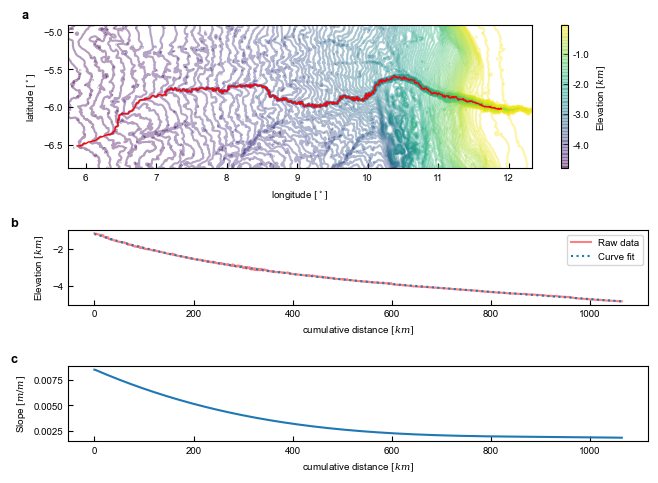

In [13]:
# curve fit
from scipy.optimize import curve_fit

def func(x, c,d,e,f,g):
    return c*x**4 + d*x**3 + e*x**2 + f*x + g
    # return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

popt, pcov = curve_fit(func, np.array(Congo_D), np.array(Congo_Z).flatten())

# path of overview of offshore Congo
Congo_overview_path = ["Raw/XYZ/Congo/Congo_all_long.xyz"]

# figure setting
fig = plt.figure(figsize=(A4['width'], A4['twothird']))
ax = plt.subplot2grid((7,1), (0,0),rowspan=3,colspan=1,fig = fig)
bx = plt.subplot2grid((7,1), (3,0),rowspan=2,colspan=1,fig = fig)
cx = plt.subplot2grid((7,1), (5,0),rowspan=2,colspan=1,fig = fig)
ax.set_xlabel(r'longitude $[^\circ]$',fontsize=A4['FSIZE'])
ax.set_ylabel(r'latitude $[^\circ]$',fontsize=A4['FSIZE'])
bx.set_xlabel(r'cumulative distance $[km]$',fontsize=A4['FSIZE'])
bx.set_ylabel(r'Elevation $[km]$',fontsize=A4['FSIZE'])
cx.set_xlabel(r'cumulative distance $[km]$',fontsize=A4['FSIZE'])
cx.set_ylabel(r'Slope $[m/m]$',fontsize=A4['FSIZE'])
ax.tick_params(axis='x',labelsize=FSIZE); ax.tick_params(axis='y',labelsize=FSIZE)
bx.tick_params(axis='x',labelsize=FSIZE); bx.tick_params(axis='y',labelsize=FSIZE)
cx.tick_params(axis='x',labelsize=FSIZE); cx.tick_params(axis='y',labelsize=FSIZE)
# cx.set_yscale('log')

# for colorbar
minE,maxE = elevation_percentileRange_from_path_list(Congo_overview_path,minp=2,maxp=95)
level = np.linspace(minE,maxE,100)
# plot geometry
data = file_reader(Congo_overview_path[0])
grids, fields = channel_interpolator(data,sigma=0)
X,Y,Z,mag = grids
mappable = ax.contour(X,Y,Z,levels = level,alpha=0.4)
#plot centreline
ax.plot(Congo_X,Congo_Y,color='red',linewidth=1)
#colorbar
cb = fig.colorbar(mappable,ticks=[-1000,-2000,-3000,-4000])
cb.ax.set_yticklabels(['-1.0', '-2.0', '-3.0','-4.0'])
cb.set_label(r'Elevation $[km]$',size=FSIZE)
# elevation
bx.plot(np.array(Congo_D)/1000,np.array(Congo_Z).flatten()/1000,alpha=0.5,color='red',label='Raw data')
# fitted curve
# bx.plot(np.array(Congo_D)/1000,func(np.array(Congo_D),*popt))
x_array = np.linspace(0,np.max(Congo_D),500)
y_array = func(x_array, *popt)
bx.plot(x_array/1000,y_array/1000,linestyle=':', label='Curve fit')
bx.legend(prop={'size': FSIZE})
cx.plot(np.array(x_array)/1000,np.gradient(-y_array,x_array) )
cb.ax.tick_params(labelsize=A4['FSIZE'])
ff.addlabels2axes([ax,bx,cx],fontsize=FSIZE*1.3)
plt.tight_layout()
plt.savefig('Export/ChannelFigures/Congo_centreline_all.pdf')
plt.show()
plt.close()


In [ ]:
from IPython.display import display, HTML
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_01.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_02.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_03.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_04.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_05.xyz',
                 ]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #1
    (1,0,5,95,0), #2
    (1,0,5,95,0), #3
    (1,0,5,95,0), #4
    (1,0,5,95,0), #5
    (1,0,5,95,0), #6
    (1,0,5,95,0), #7
    (1,0,5,95,2), #8
    (1,0,5,95,0), #9
    (1,0,5,95,0)  #10
]

file_name = [
    'Hikurangi_01.pdf',
    'Hikurangi_02.pdf',
    'Hikurangi_03.pdf',
    'Hikurangi_04.pdf',
    'Hikurangi_05.pdf',
    'Hikurangi_06.pdf',
    'Hikurangi_07.pdf',
    'Hikurangi_08.pdf',
    'Hikurangi_09.pdf',
    'Hikurangi_10.pdf',
]
sight_angles = [
    np.pi/4, #01
    np.pi/4, #02
    np.pi/4, #03
    np.pi/4, #04
    np.pi/4, #05
    np.pi/4, #06
    np.pi/4, #07
    np.pi/4, #08
    np.pi/4, #09
    np.pi/4 #10
]

start_pos = [
    'left', # 01
    'bottom', # 02
    'bottom', # 03
    'bottom', # 04
    'bottom', # 05
    'left', # 06
    'left', # 07
    'left', # 08
    'bottomleft', # 09
    'left' # 10
]
radius = [
    0.02,
    0.02,
    0.02,
    0.02,
    0.02,
    0.02,
    0.02,
    0.02,
    0.02,
    0.02
]
success_centreline = [
    True, 
    True,
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True,
    True
]
# clp_x,clp_y
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5)
    ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
    ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red')
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP05 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi01to05.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Hikurangi01to05.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_06.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_07.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_08.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_09.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_10.xyz'
                 ]
centreline_path = [
    '',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi/Hikurangi_07_centre.xyz',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #6
    (1,0,5,95,0), #7
    (1,0,5,95,2), #8
    (1,0,5,95,1), #9
    (1,0,5,95,0)  #10
]

file_name = [
    'Hikurangi_06.pdf',
    'Hikurangi_07.pdf',
    'Hikurangi_08.pdf',
    'Hikurangi_09.pdf',
    'Hikurangi_10.pdf',
]
sight_angles = [
    np.pi/4, #06
    np.pi/4, #07
    np.pi/4, #08
    np.pi/4, #09
    np.pi/4 #10
]

start_pos = [
    'left', # 06
    'left', # 07
    'left', # 08
    'left', # 09
    'left' # 10
]
radius = [
    0.02,
    0.02,
    0.02,
    0.03,
    0.02
]
success_centreline = [
    True, 
    False,
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP05
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red')
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP10 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hikurangi06to10.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Hikurangi06to10.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_01.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_02.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_03.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_04.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_05.xyz'
                 ]
centreline_path = [
    '',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #01
    (1,0,5,95,0), #02
    (1,0,5,95,0), #03
    (1,0,5,95,1), #04
    (1,0,5,95,0)  #05
]

file_name = [
    'Hokitika_01.pdf',
    'Hokitika_02.pdf',
    'Hokitika_03.pdf',
    'Hokitika_04.pdf',
    'Hokitika_05.pdf',
]
sight_angles = [
    np.pi/4, #01
    np.pi/4, #02
    np.pi/4, #03
    np.pi/4, #04
    np.pi/4 #05
]

start_pos = [
    'right', # 01
    'right', # 02
    'bottom', # 03
    'bottom', # 04
    'bottom' # 05
]
radius = [
    0.02, #01
    0.05, #02
    0.02, #03
    0.04, #04
    0.02  #05
]
success_centreline = [
    True, 
    True,
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True,
    True
]
adjust_list = [
    []
]
# clp_x,clp_y = CLP05
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    if path == '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_04.xyz':
        CX = np.array(CX)
        CX[len(CX)-10:] = np.linspace(CX[-11],CX[-1]-0.034,10)
        CX = list(CX)
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red')
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP05 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika01to05.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Hokitika01to05.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_06.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_07.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_08.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_09.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_10.xyz'
                 ]
centreline_path = [
    '',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #01
    (1,0,5,95,0), #02
    (1,0,5,95,0), #03
    (1,0,5,95,0), #04
    (1,0,5,95,0)  #05
]

file_name = [
    'Hokitika_06.pdf',
    'Hokitika_07.pdf',
    'Hokitika_08.pdf',
    'Hokitika_09.pdf',
    'Hokitika_10.pdf',
]
sight_angles = [
    np.pi/4, #01
    np.pi/4, #02
    np.pi/4, #03
    np.pi/4, #04
    np.pi/4 #05
]

start_pos = [
    'right', # 06
    'left', # 07
    'bottom', # 08
    'right', # 09
    'right' # 10
]
radius = [
    0.02, #06
    0.02, #07
    0.02, #08
    0.02, #09
    0.02  #10
]
success_centreline = [
    True, 
    True,
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True,
    True
]
clp_x,clp_y = CLP05
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    if path == '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_06.xyz':
        CX = CX[:-10]; CY = CY[:-10]; CZ = CZ[:-10]; CD = CD[:-10]; DEV = DEV[:-10];
    else:
        CX = CX[:-1]; CY = CY[:-1]; CZ = CZ[:-1]; CD = CD[:-1]; DEV = DEV[:-1];
#     if path == '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_09.xyz':
#         CY[-1] += -0.015
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5,zorder=2)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5,zorder=0)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue',zorder=5)
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red',zorder=10)
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP10 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4,zorder=0)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika06to10.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Hokitika06to10.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_11.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_12r.xyz',
                 ]
centreline_path = [
    '',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #11
    (1,0,5,95,0), #12
    (1,0,5,95,0), #13
    (1,0,5,95,0), #04
    (1,0,5,95,0)  #05
]

file_name = [
    'Hokitika_11.pdf',
    'Hokitika_12.pdf',
    'Hokitika_13.pdf'
]
sight_angles = [
    np.pi/3, #01
    np.pi/4, #02
    np.pi/4, #03
    np.pi/4, #04
    np.pi/4 #05
]

start_pos = [
    'right', # 11
    'right', # 12
    'right', # 13
    'right', # 09
    'right' # 10
]
radius = [
    0.02, #06
    0.02, #07
    0.02, #08
    0.02, #09
    0.02  #10
]
success_centreline = [
    True, 
    True,
    True,
    True,
    True
]
cuts = [
    True,
    True,
    True,
    True,
    True
]
end_ind = [
    144,
    -1,
    -1
]
clp_x,clp_y = CLP10
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    if path == '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika/Hokitika_12r.xyz':
        end_ind = 70
        CX = CX[:end_ind]; CY = CY[:end_ind]; CZ = CZ[:end_ind]; CD = CD[:end_ind]; DEV = DEV[:end_ind];
    else:
        end_ind = -5
        CX = CX[:end_ind]; CY = CY[:end_ind]; CZ = CZ[:end_ind]; CD = CD[:end_ind]; DEV = DEV[:end_ind];
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue')
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red')
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP13 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Hokitika11to13.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Hokitika11to13.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_01.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_02.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_03.xyz',
                 ]
centreline_path = [
    '',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,0), #01
    (1,0,5,95,0), #02
    (1,0,5,95,0), #03
    (1,0,5,95,0), #04
    (1,0,5,95,0), #05
    (1,0,5,95,0), #06
    (1,0,5,95,0)  #07
]

file_name = [
    'Bounty_01.pdf',
    'Bounty_02.pdf',
    'Bounty_03.pdf',
    'Bounty_04.pdf',
    'Bounty_05.pdf',
    'Bounty_06.pdf',
    'Bounty_07.pdf',
]
sight_angles = [
    np.pi/4, #01
    np.pi/4, #02
    np.pi/4, #03
    np.pi/4, #04
    np.pi/4, #05
    np.pi/4, #06
    np.pi/4 #07
]

start_pos = [
    'left', # 01
    'left', # 02
    'left', # 03
    'left', # 04
    'left', # 05
    'left', # 06
    'left'  # 07
]
radius = [
    0.02, #01
    0.02, #02
    0.02, #03
    0.02, #04
    0.02, #05
    0.02, #06
    0.02  #07
]
success_centreline = [
    True, #01 
    True, #02
    True, #03
    True, #04
    True, #05
    True, #06
    True  #07
]
cuts = [
    True, # 01
    True, # 02
    True, # 03
    True, # 04
    True, # 05
    True, # 06
    True  # 07
]
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    end_ind = -5
    CX = CX[:end_ind]; CY = CY[:end_ind]; CZ = CZ[:end_ind]; CD = CD[:end_ind]; DEV = DEV[:end_ind];
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5,zorder=1)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5,zorder=0)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue',zorder=2)
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red',zorder=3)
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP07 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Bounty01to03.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Bounty01to03.csv')

In [ ]:
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_04.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_05.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_06.xyz',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/BountyTrough/Bounty_07.xyz'
                 ]
centreline_path = [
    '',
    '',
    '',
    ''
]
# expand rate of radius, threshold of minimum std, lower and upper height-weight percentile
debug_param = [
    (1,0,5,95,1), #04
    (1,0,5,95,1), #05
    (1,0,5,95,0), #06
    (1,0,5,95,0), #07
]

file_name = [
    'Bounty_04.pdf',
    'Bounty_05.pdf',
    'Bounty_06.pdf',
    'Bounty_07.pdf',
]
sight_angles = [
    np.pi/6, #04
    np.pi/6, #05
    np.pi/4, #06
    np.pi/4, #07
]

start_pos = [
    'left', # 04
    'left', # 05
    'left', # 06
    'left'  # 07
]
radius = [
    0.04, #04
    0.03, #05
    0.03, #06
    0.03 #07
]
success_centreline = [
    True, #04
    True, #05
    True, #06
    True  #07
]
cuts = [
    True, # 04
    True, # 05
    True, # 06
    True  # 07
]
CX_all = []
CY_all = []
CZ_all = []
step = 0.005
count = 0
for i,path in enumerate(FILE_PATH_LIST):
    print(path)
    # Image analysis
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    if success_centreline[i] == True:
        if count == 0 :
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i])
        elif success_centreline[i-1] == False:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
        elif success_centreline[i-1] == True:
            centre_line = detect_centreline(grids,fields,radius[i],step,debug_param[i],moment_num = moment_num[i],start_position = start_pos[i],start_loc=[clp_x,clp_y])
    else:
        centre_line = read_centreline_fromXYZ(centreline_path[i],grids,fields,cut = cuts[i])
    # plot figure
    X,Y,Z,mag = grids
    CX,CY,CZ,CD,DEV = centre_line
    print(len(CX))
    end_ind = -1
    CX = CX[:end_ind]; CY = CY[:end_ind]; CZ = CZ[:end_ind]; CD = CD[:end_ind]; DEV = DEV[:end_ind];
    clp_x = CX[-1]
    clp_y = CY[-1]
    print('clp:',(clp_x,clp_y))
    CX_all += CX[1:]
    CY_all += CY[1:]
    CZ_all += CZ[1:]
    fig = plt.figure(figsize=(A4_width*2, A4_twothird))
    ax = plt.subplot2grid((1,2), (0,0),rowspan=1,colspan=1,fig = fig)
    bx = plt.subplot2grid((1,2), (0,1),rowspan=1,colspan=1,fig = fig)
    level = np.linspace(np.min(Z),np.max(Z),100)
    ax.plot(CX,CY,color='red',linewidth=1,alpha=0.5,zorder=1)
#     ax.set_xlim([np.min(CX)-radius[i],np.max(CX)+radius[i]])
#     ax.set_ylim([np.min(CY)-radius[i],np.max(CY)+radius[i]])
    bx.plot(CZ)
    ax.contour(X, Y, Z,levels = level,alpha=0.5,zorder=0)
    ax.scatter([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)],color='blue',zorder=2)
    for x, y, c in zip([CX[i] for i in np.arange(0,len(CX)-1,50).astype(int)], [CY[i] for i in np.arange(0,len(CY)-1,50).astype(int)], [str(i) for i in np.arange(0,len(CY)-1,50).astype(int)]):
        ax.text(x,y,c,color='red',zorder=3)
    ax.grid()
    plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+file_name[i])
    plt.show()
    plt.close()
    count += 1
    
CLP07 = (clp_x,clp_y)
fig = plt.figure(figsize=(A4_width, A4_half))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
minE,maxE = elevation_percentileRange_from_path_list(FILE_PATH_LIST,minp=1,maxp=95)
level = np.linspace(minE,maxE,100)
for path in FILE_PATH_LIST:
    data = file_reader(path)
    grids, fields = channel_interpolator(data,sigma=0)
    X,Y,Z,mag = grids
    ax.contour(X,Y,Z,levels = level,alpha=0.4)
ax.plot(CX_all,CY_all,color='red',linewidth=1)
plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Bounty04to07.pdf')
plt.show()
plt.close()
df = pd.DataFrame()
df['x'] = CX_all
df['y'] = CY_all
df.to_csv('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Bounty04to07.csv')

In [ ]:
import rasterio
from rasterio.plot import show
import cmocean.cm as cm
FILE_PATH = '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Congo/Congo_all.xyz'
PHOTO_PATH = '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Congo/Congo_all.tif'
fig = plt.figure(figsize=(A4_twothird*2, A4_half*2))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
# Plot image
# src = rasterio.open(PHOTO_PATH)
# show((src, 1), cmap='Greys_r', interpolation='none', ax=ax)
# display contour of elevation
minE,maxE = elevation_percentileRange_from_path_list([FILE_PATH],minp=1,maxp=95)
level = np.linspace(minE,maxE,50)
data = file_reader(FILE_PATH)
grids, fields = channel_interpolator(data,sigma=0)
X,Y,Z,mag = grids
ax.contour(X,Y,Z,levels = level,alpha=0.5,colors=['black'],linestyle='-')

img = plt.imread(PHOTO_PATH)
ax.imshow(img,extent=[np.min(X),np.max(X),np.min(Y),np.max(Y)])
# Import and display centreline
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo03to08.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo09to11.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo12to14.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo15to18.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo19to22.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo23to26.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo27to30.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo31to34.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo35to38.csv'
]
for path in FILE_PATH_LIST:
    centre = pd.read_csv(path)
    ax.plot(centre.x,centre.y,color='red',linewidth=2)
ax.plot([5.5,5.5+(100/111)],[-4.9,-4.9],linewidth=10,color='black')
ax.text(5.5+(100/111)/5,-4.8,'100 km',fontsize=20)
ax.set_xlim([5,13])
ax.set_ylim([-4.5,-7.5])
ax.invert_yaxis();

plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+'Congo_all.pdf')
plt.show()
plt.close()

fig = plt.figure(figsize=(A4_twothird*2, A4_half*3))
ax = plt.subplot2grid((1,1), (0,0),rowspan=1,colspan=1,fig = fig)
# Plot image
# src = rasterio.open(PHOTO_PATH)
# show((src, 1), cmap='Greys_r', interpolation='none', ax=ax)
# display contour of elevation
minE,maxE = elevation_percentileRange_from_path_list([FILE_PATH],minp=1,maxp=95)
level = np.linspace(minE,maxE,50)
data = file_reader(FILE_PATH)
grids, fields = channel_interpolator(data,sigma=0)
X,Y,Z,mag = grids
ax.contour(X,Y,Z,levels = level,alpha=0.5,colors=['black'])

img = plt.imread(PHOTO_PATH)
ax.imshow(img,extent=[np.min(X),np.max(X),np.min(Y),np.max(Y)])
# Import and display centreline
FILE_PATH_LIST = [
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo03to08.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo09to11.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo12to14.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo15to18.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo19to22.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo23to26.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo27to30.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo31to34.csv',
    '/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/Centreline/Congo35to38.csv'
]
for path in FILE_PATH_LIST:
    centre = pd.read_csv(path)
    ax.plot(centre.x,centre.y,color='red',linewidth=2,alpha=0.5)
ax.plot([5.5,5.5+(100/111)],[-4.9,-4.9],linewidth=10,color='black')
ax.text(5.5+(100/111)/5,-4.8,'100 km',fontsize=20)
ax.set_xlim([5,13])
ax.set_ylim([-4.0,-8.0])
ax.invert_yaxis();

plt.tight_layout()
plt.savefig('/Users/fukudasoujirou/Documents/Hull_Uni/Data/Meanders/'+'Congo_all_withoutscale.pdf')
plt.show()
plt.close()